In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 114.2 MB/s eta 0:00:00


In [ ]:
!pip install -q tf-models-official==2.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 189.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 84.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [ ]:
import os
import shutil

import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.8.4
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We have first preprocessed the collected data using the python package tweet-preprocessor. This allows us to do a basic clean on the data where we remove hashtags, emojis and urls from the tweets. We then divide our data into a training set, a test set as well as a validation set. We will train the model weights using the training set while testing the loss and accuracy on the validation set after each epoch. This will allow us to select the correct number of epochs for which we should train our model to maximize accuracy without overfitting on the training set. We will as a last step also test our model on the test data to check whether we indeed get good results.

We load the data using the tf.data API to allow for more efficient training.

In order to make the training of our model as efficient as possible we will divide our data into batches so the the computer does not have to store all the data in memory at each epoch which would be expensive as the model will update the weights after each batch (see when and why to use bacthes tds). Furthermore, we will also apply pre-fetching to our data. Without pre-fetching, after every training step we have to wait for the next batch to be read before training. However, with prefetching, while we train on a certain batch, the next batch will start being read so that it is ready for training once the previous batch has been trained. 


In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# training and validation dataset

train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)))

train_val_set_size = len(list(train_val_data))
val_n = int(0.2*train_val_set_size)

train_data = train_val_data.skip(val_n).batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = train_val_data.take(val_n).batch(batch_size)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

# test dataset

test_data = tf.data.experimental.CsvDataset(["test_bert"], [tf.string,tf.int32] ,select_cols=[2,3])
test_data = test_data.batch(batch_size)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

As an initial model we will use the pretrained bert model small_bert/bert_en_uncased_L-6_H-128_A-2 which is a smaller bert. This will allow for shorter fine tuning time compared to larger models like the original BERT-Base. Pre-training means that the initial architecture was trained using a MLM (masked language model) on the content of Wikipedia and Bookscorpus. This is thus a general model for english that we will fine tune for our needs namely language classification.

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-6_H-128_A-2'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


preprocess model to tokenize text which we then input into the bert model

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

To perform the classification task we will thus use as basis the pre-trained small BERT model to which we add a dropout layer which will help in our quest to avoid overfitting on the training data by randomly dropping data points out of training thus in essence creating slightly dissimilar datasets on which the model is trained. 
We will then also add a dense layer with only one unit meaning the output will be a classifier.  

In [ ]:
def build_classifier_model(dropout):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(dropout)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
def build_classifier_model_no_dropout():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  #net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
steps_per_epoch = train_val_set_size - val_n
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

## Grid search for dropout

0.1 dropout

In [ ]:
classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_data,
                               validation_data=val_data,
                               epochs=epochs)
!mkdir saved_model
classifier_model.save('saved_model/bert_misinf') 

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1
Epoch 1/15
229/229 [==============================] - 382s 2s/step - loss: 0.8502 - binary_accuracy: 0.5092 - val_loss: 0.7109 - val_binary_accuracy: 0.7131
Epoch 2/15
229/229 [==============================] - 373s 2s/step - loss: 0.6544 - binary_accuracy: 0.6703 - val_loss: 0.5247 - val_binary_accuracy: 0.6885
Epoch 3/15
229/229 [==============================] - 374s 2s/step - loss: 0.5090 - binary_accuracy: 0.7380 - val_loss: 0.4073 - val_binary_accuracy: 0.7721
Epoch 4/15
229/229 [==============================] - 364s 2s/step - loss: 0.4106 - binary_accuracy: 0.8049 - val_loss: 0.3217 - val_binary_accuracy: 0.8519
Epoch 5/15
229/229 [==============================] - 356s 2s/step - loss: 0.3347 - binary_accuracy: 0.8553 - val_loss: 0.2672 - val_binary_accuracy: 0.8820
Epoch 6/15
229/229 [==============================] - 359s 2s/step - loss: 0.2863 - binary_accuracy: 0.8825 - val_loss: 0.2

In [ ]:
loss, accuracy = classifier_model.evaluate(test_data)

72/72 [==============================] - 29s 402ms/step - loss: 0.1035 - binary_accuracy: 0.9703


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


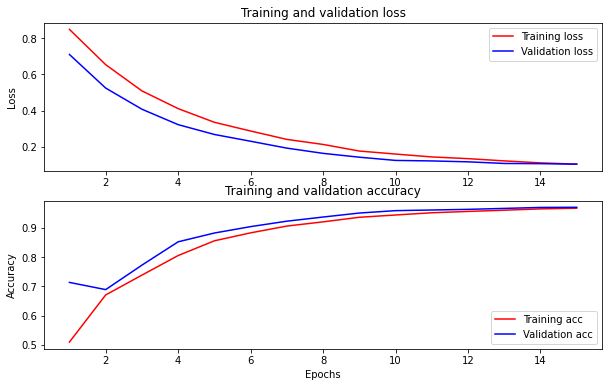

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

As we can see, the validation accuracy is always higher than those same metrics evaluated on the training set. This seems to indicate that our model is not overfitting and is in fact generalizing quite well. Maybe this is also because of dropout. The accuracy on the training, validation and test set after 5 epochs are 0.9266, 0.9497 and 0.9515 respectively. 

In [ ]:
files.download('/content/saved_model/bert_misinf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# need compile=False cause otherwise will not load properly cause custom optimizer
model_bert = tf.keras.models.load_model('saved_model/bert_misinf', compile=False)  

In [ ]:
classifier_model_no_dropout = build_classifier_model_no_dropout()
classifier_model_no_dropout.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model_no_dropout.fit(x=train_data, validation_data=val_data, epochs=epochs)
!mkdir saved_model_no_dropout
classifier_model.save('saved_model/bert_misinf_no_dropout') 

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1
Epoch 1/15
229/229 [==============================] - 378s 2s/step - loss: 0.8841 - binary_accuracy: 0.4264 - val_loss: 0.7533 - val_binary_accuracy: 0.6432
Epoch 2/15
229/229 [==============================] - 349s 2s/step - loss: 0.6763 - binary_accuracy: 0.6539 - val_loss: 0.5827 - val_binary_accuracy: 0.6727
Epoch 3/15
229/229 [==============================] - 348s 2s/step - loss: 0.5379 - binary_accuracy: 0.7010 - val_loss: 0.4644 - val_binary_accuracy: 0.7301
Epoch 4/15
229/229 [==============================] - 350s 2s/step - loss: 0.4400 - binary_accuracy: 0.7793 - val_loss: 0.3761 - val_binary_accuracy: 0.8230
Epoch 5/15
229/229 [==============================] - 346s 2s/step - loss: 0.3681 - binary_accuracy: 0.8398 - val_loss: 0.3061 - val_binary_accuracy: 0.8710
Epoch 6/15
229/229 [==============================] - 353s 2s/step - loss: 0.3100 - binary_accuracy: 0.8743 - val_loss: 0.2

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


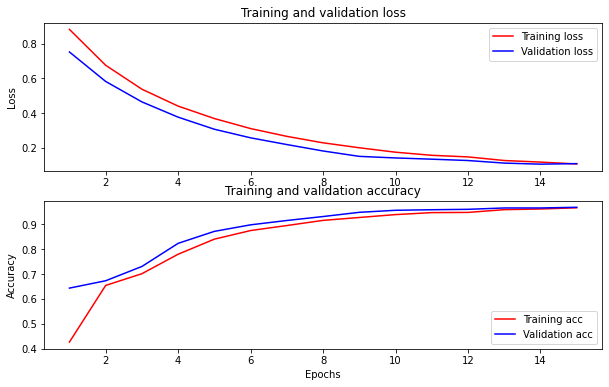

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

 **FOR CV NEED NEW TRAIN SET AS VALIDATION SET NO LONGER NEEDED**

We will then apply k-fold cross validation which will allow us to get a better and more realistic estimate of how our model will perform when applied to unseen data. K-fold cross validation works by splitting our training dataset into K groups then at each epoch, we will take a group to hold out as a validation set, train the model on the remaining training data and evaluate on the validation set. We will do this for each of the K-folds and then average the performance obtained on each validation fold. We will initially set the number of folds to 5 to keep the training time low.

Next steps:
- somehow need to find out if we should use dropout maybe find optimal epochs then grid search for dropout then verify using cross-validation
- train up to 15 epochs to find optimal number of epochs for training from looking at graph and seeing where validation accuracy gets lower than test accuracy, ie 
- train CV with/without dropout for 5 folds to evaluate model
(say source where we take the value of 5 folds) 
- go upto 20 epochs


We thus have chosen a BERT model to classify the Tweets as from recent literature BERT has shown to the most accurate NLP model. To this base bert architercture, we need to add a couple extra layers that will allow us to fine tune BERT for the classification problem at hand. Thus the most important added layer is a dense layer that will be used for the classification. We can also add a dropout layer. This is where we will apply hyperparameter tuning techniques that will help us to select the ideal value of the dropout as well as the ideal number of epochs that our model should be trained for in order to get the highest accuracy (see hyperparameter tuning methods ie grid search). We can evaluate our resulting models using k-fold cross validation. For k-fold cross validation, we will need to divide our dataset into a test set and another set used for training that we will divide into k non-intersecting folds. We will then train our model k times, at each iteration, we will keep one fold as a validation set while training the data on the k-1 remaining folds. We can then use the average accuracy over all trained models to evaluate the performance of our model. 

Explanation from https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/:
The k-fold cross-validation procedure divides a limited dataset into k non-overlapping folds. Each of the k folds is given an opportunity to be used as a held back test set whilst all other folds collectively are used as a training dataset. A total of k models are fit and evaluated on the k holdout test sets and the mean performance is reported.

In [ ]:
split_size = int(0.2*train_val_set_size)

cv_1 = train_val_data.take(split_size).batch(batch_size)
cv_1 = cv_1.cache().prefetch(buffer_size=AUTOTUNE)
m1 = train_val_data.skip(split_size)
cv_2 = m1.take(split_size).batch(batch_size)
cv_2 = cv_2.cache().prefetch(buffer_size=AUTOTUNE)
m2 = m1.skip(split_size)
cv_3 = m2.take(split_size).batch(batch_size)
cv_3 = cv_3.cache().prefetch(buffer_size=AUTOTUNE)
m3 = m2.skip(split_size)
cv_4 = m3.take(split_size).batch(batch_size)
cv_4 = cv_4.cache().prefetch(buffer_size=AUTOTUNE)
cv_5 = m3.skip(split_size).batch(batch_size)
cv_5 = cv_5.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
acc_fold = []
val_acc_fold = []
loss_fold = []
val_loss_fold = []

# fold 1
classifier_model_cv1 = build_classifier_model_no_dropout()
classifier_model_cv1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv1 = classifier_model_cv1.fit(x=cv_2.concatenate(cv_3).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_1,
                               epochs=epochs)
history_dict_cv1 = history_cv1.history
acc_fold.append(history_dict_cv1['binary_accuracy'])
val_acc_fold.append(history_dict_cv1['val_binary_accuracy'])
loss_fold.append(history_dict_cv1['loss'])
val_loss_fold.append(history_dict_cv1['val_loss'])

# fold 2
classifier_model_cv2 = build_classifier_model_no_dropout()
classifier_model_cv2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv2 = classifier_model_cv2.fit(x=cv_1.concatenate(cv_3).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_2,
                               epochs=epochs)
history_dict_cv2 = history_cv2.history
acc_fold.append(history_dict_cv2['binary_accuracy'])
val_acc_fold.append(history_dict_cv2['val_binary_accuracy'])
loss_fold.append(history_dict_cv2['loss'])
val_loss_fold.append(history_dict_cv2['val_loss'])

#fold 3
classifier_model_cv3 = build_classifier_model_no_dropout()
classifier_model_cv3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv3 = classifier_model_cv3.fit(x=cv_2.concatenate(cv_1).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_3,
                               epochs=epochs)
history_dict_cv3 = history_cv3.history
acc_fold.append(history_dict_cv3['binary_accuracy'])
val_acc_fold.append(history_dict_cv3['val_binary_accuracy'])
loss_fold.append(history_dict_cv3['loss'])
val_loss_fold.append(history_dict_cv3['val_loss'])

# fold 4
classifier_model_cv4 = build_classifier_model_no_dropout()
classifier_model_cv4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv4 = classifier_model_cv4.fit(x=cv_2.concatenate(cv_3).concatenate(cv_1).concatenate(cv_5),
                               validation_data=cv_4,
                               epochs=epochs)
history_dict_cv4 = history_cv4.history
acc_fold.append(history_dict_cv4['binary_accuracy'])
val_acc_fold.append(history_dict_cv4['val_binary_accuracy'])
loss_fold.append(history_dict_cv4['loss'])
val_loss_fold.append(history_dict_cv4['val_loss'])

#fold 5
classifier_model_cv5 = build_classifier_model_no_dropout()
classifier_model_cv5.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv5 = classifier_model_cv5.fit(x=cv_2.concatenate(cv_3).concatenate(cv_4).concatenate(cv_1),
                               validation_data=cv_5,
                               epochs=epochs)
history_dict_cv5 = history_cv5.history
acc_fold.append(history_dict_cv5['binary_accuracy'])
val_acc_fold.append(history_dict_cv5['val_binary_accuracy'])
loss_fold.append(history_dict_cv5['loss'])
val_loss_fold.append(history_dict_cv5['val_loss'])

# print
print(acc_fold)
print(val_acc_fold)
print(loss_fold)
print(val_loss_fold)


Epoch 1/15
232/232 [==============================] - 365s 2s/step - loss: 0.7240 - binary_accuracy: 0.6710 - val_loss: 0.6148 - val_binary_accuracy: 0.6710
Epoch 2/15
232/232 [==============================] - 351s 2s/step - loss: 0.5707 - binary_accuracy: 0.6740 - val_loss: 0.4801 - val_binary_accuracy: 0.6902
Epoch 3/15
232/232 [==============================] - 348s 2s/step - loss: 0.4611 - binary_accuracy: 0.7328 - val_loss: 0.3727 - val_binary_accuracy: 0.7984
Epoch 4/15
232/232 [==============================] - 348s 2s/step - loss: 0.3756 - binary_accuracy: 0.8138 - val_loss: 0.3094 - val_binary_accuracy: 0.8443
Epoch 5/15
232/232 [==============================] - 348s 2s/step - loss: 0.3226 - binary_accuracy: 0.8541 - val_loss: 0.2692 - val_binary_accuracy: 0.8770
Epoch 6/15
232/232 [==============================] - 345s 1s/step - loss: 0.2774 - binary_accuracy: 0.8868 - val_loss: 0.2354 - val_binary_accuracy: 0.8945
Epoch 7/15
232/232 [==============================] - 347s

We now use grid search to find the optimal dropout value while training for 15 epochs

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# training and validation dataset

train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)))

train_val_set_size = len(list(train_val_data))
val_n = int(0.2*train_val_set_size)

train_data = train_val_data.skip(val_n).batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = train_val_data.take(val_n).batch(batch_size)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

# test dataset

test_data = tf.data.experimental.CsvDataset(["test_bert"], [tf.string,tf.int32] ,select_cols=[2,3])
test_data = test_data.batch(batch_size)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

epochs = 25
list_dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for dropout in list_dropouts:
  print(f"Current dropout is {dropout}")
  classifier = build_classifier_model(dropout)
  classifier.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  history = classifier.fit(x=train_data, validation_data=val_data, epochs=epochs)
  history_dict=history.history
  print(f"For dropout {dropout}")
  print(history_dict['loss'])
  print(history_dict['val_loss'])
  print(history_dict['binary_accuracy'])
  print(history_dict['val_binary_accuracy'])



Current dropout is 0
Epoch 1/20
229/229 [==============================] - 469s 2s/step - loss: 0.7490 - binary_accuracy: 0.6146 - val_loss: 0.6863 - val_binary_accuracy: 0.6798
Epoch 2/20
229/229 [==============================] - 421s 2s/step - loss: 0.6283 - binary_accuracy: 0.6786 - val_loss: 0.5486 - val_binary_accuracy: 0.6869
Epoch 3/20
229/229 [==============================] - 422s 2s/step - loss: 0.5167 - binary_accuracy: 0.7103 - val_loss: 0.4321 - val_binary_accuracy: 0.7459
Epoch 4/20
229/229 [==============================] - 421s 2s/step - loss: 0.4178 - binary_accuracy: 0.7881 - val_loss: 0.3424 - val_binary_accuracy: 0.8344
Epoch 5/20
229/229 [==============================] - 428s 2s/step - loss: 0.3394 - binary_accuracy: 0.8507 - val_loss: 0.2795 - val_binary_accuracy: 0.8803
Epoch 6/20
229/229 [==============================] - 421s 2s/step - loss: 0.2898 - binary_accuracy: 0.8827 - val_loss: 0.2356 - val_binary_accuracy: 0.9055
Epoch 7/20
229/229 [=================

NameError: ignored

In [ ]:
print(train_loss)
print(val_loss)
print(train_accuracies)
print(val_accuracies)

In [ ]:
classifier_drop_20 = build_classifier_model(0.2)
classifier_drop_20.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history_drop_20 = classifier_drop_20.fit(x=train_data, validation_data=val_data, epochs=epochs)

Epoch 1/15
229/229 [==============================] - 370s 2s/step - loss: 0.7765 - binary_accuracy: 0.5682 - val_loss: 0.6820 - val_binary_accuracy: 0.6885
Epoch 2/15
229/229 [==============================] - 356s 2s/step - loss: 0.6396 - binary_accuracy: 0.6764 - val_loss: 0.5261 - val_binary_accuracy: 0.7027
Epoch 3/15
229/229 [==============================] - 351s 2s/step - loss: 0.5227 - binary_accuracy: 0.7275 - val_loss: 0.4291 - val_binary_accuracy: 0.7689
Epoch 4/15
229/229 [==============================] - 352s 2s/step - loss: 0.4353 - binary_accuracy: 0.7887 - val_loss: 0.3547 - val_binary_accuracy: 0.8301
Epoch 5/15
229/229 [==============================] - 352s 2s/step - loss: 0.3624 - binary_accuracy: 0.8433 - val_loss: 0.2874 - val_binary_accuracy: 0.8770
Epoch 6/15
229/229 [==============================] - 354s 2s/step - loss: 0.3055 - binary_accuracy: 0.8735 - val_loss: 0.2416 - val_binary_accuracy: 0.9005
Epoch 7/15
229/229 [==============================] - 350s

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# training and validation dataset

train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)))

train_val_set_size = len(list(train_val_data))
val_n = int(0.2*train_val_set_size)

train_data = train_val_data.skip(val_n).batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = train_val_data.take(val_n).batch(batch_size)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

# test dataset

test_data = tf.data.experimental.CsvDataset(["test_bert"], [tf.string,tf.int32] ,select_cols=[2,3])
test_data = test_data.batch(batch_size)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

epochs = 25
list_dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for dropout in list_dropouts:
  print(f"Current dropout is {dropout}")
  classifier = build_classifier_model(dropout)
  classifier.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  history = classifier.fit(x=train_data, validation_data=val_data, epochs=epochs)
  history_dict=history.history
  print(f"For dropout {dropout}")
  print(history_dict['loss'])
  print(history_dict['val_loss'])
  print(history_dict['binary_accuracy'])
  print(history_dict['val_binary_accuracy'])

## Grid search for batch size

In [ ]:
epochs = 25
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# training and validation dataset

train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)))

train_val_set_size = len(list(train_val_data))
val_n = int(0.2*train_val_set_size)

train_data = train_val_data.skip(val_n).batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = train_val_data.take(val_n).batch(batch_size)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

# test dataset

test_data = tf.data.experimental.CsvDataset(["test_bert"], [tf.string,tf.int32] ,select_cols=[2,3])
test_data = test_data.batch(batch_size)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = train_val_set_size - val_n
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

train_loss = []
val_loss = []
train_accuracies = []
val_accuracies = []

init_lr = 0.0001
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier = build_classifier_model(0)
classifier.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history = classifier.fit(x=train_data, validation_data=val_data, epochs=epochs)
history_dict=history.history
train_loss.append(history_dict['loss'])
val_loss.append(history_dict['val_loss'])
train_accuracies.append(history_dict['binary_accuracy'])
val_accuracies.append(history_dict['val_binary_accuracy'])
print(history_dict['loss'])
print(history_dict['val_loss'])
print(history_dict['binary_accuracy'])
print(history_dict['val_binary_accuracy'])

Epoch 1/25
458/458 [==============================] - 480s 1s/step - loss: 1.1269 - binary_accuracy: 0.7002 - val_loss: 0.5100 - val_binary_accuracy: 0.6940
Epoch 2/25
458/458 [==============================] - 461s 1s/step - loss: 0.4109 - binary_accuracy: 0.8007 - val_loss: 0.2879 - val_binary_accuracy: 0.8672
Epoch 3/25
458/458 [==============================] - 461s 1s/step - loss: 0.2668 - binary_accuracy: 0.8842 - val_loss: 0.1939 - val_binary_accuracy: 0.9148
Epoch 4/25
458/458 [==============================] - 467s 1s/step - loss: 0.1898 - binary_accuracy: 0.9256 - val_loss: 0.1479 - val_binary_accuracy: 0.9503
Epoch 5/25
458/458 [==============================] - 464s 1s/step - loss: 0.1586 - binary_accuracy: 0.9463 - val_loss: 0.1628 - val_binary_accuracy: 0.9497
Epoch 6/25
458/458 [==============================] - 466s 1s/step - loss: 0.1246 - binary_accuracy: 0.9578 - val_loss: 0.1305 - val_binary_accuracy: 0.9634
Epoch 7/25
458/458 [==============================] - 469s

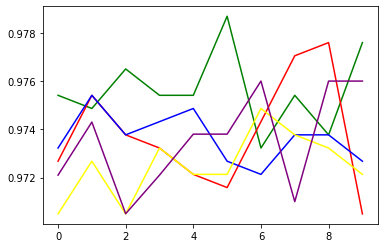

In [ ]:
val_accuracy_16 = [0.693989098072052, 0.8672131299972534, 0.9147540926933289, 0.9502732157707214, 0.9497267603874207, 0.9633879661560059, 0.9677595496177673, 0.9704918265342712, 0.9721311330795288, 0.9748634099960327, 0.9754098653793335, 0.9721311330795288, 0.9743169546127319, 0.9748634099960327, 0.9754098653793335, 0.9748634099960327, 0.9765027165412903, 0.9754098653793335, 0.9754098653793335, 0.9786885380744934, 0.9732240438461304, 0.9754098653793335, 0.9737704992294312, 0.9775956273078918, 0.9721311330795288]
val_accuracy_32 = [0.6907103657722473, 0.8098360896110535, 0.8748633861541748, 0.9147540926933289, 0.9442622661590576, 0.9595628380775452, 0.9683060050010681, 0.9710382223129272, 0.9721311330795288, 0.9721311330795288, 0.9726775884628296, 0.971584677696228, 0.9743169546127319, 0.9732240438461304, 0.9726775884628296, 0.9754098653793335, 0.9737704992294312, 0.9732240438461304, 0.9721311330795288, 0.971584677696228, 0.9743169546127319, 0.9770491719245911, 0.9775956273078918, 0.9704918265342712, 0.9721311330795288]
val_accuracy_64 = [0.6710382699966431, 0.7273223996162415, 0.848633885383606, 0.8868852257728577, 0.922950804233551, 0.9437158703804016, 0.9551912546157837, 0.9639344215393066, 0.9677595496177673, 0.9704918265342712, 0.971584677696228, 0.9732240438461304, 0.9721311330795288, 0.9737704992294312, 0.9732240438461304, 0.9754098653793335, 0.9737704992294312, 0.9743169546127319, 0.9748634099960327, 0.9726775884628296, 0.9721311330795288, 0.9737704992294312, 0.9737704992294312, 0.9726775884628296, 0.9721311330795288]
val_accuracy_128 = [0.3540983498096466, 0.6715847253799438, 0.7759562730789185, 0.8409836292266846, 0.897267758846283, 0.9409835934638977, 0.960109293460846, 0.965573787689209, 0.9704918265342712, 0.9699453711509705, 0.9693989157676697, 0.9688524603843689, 0.9693989157676697, 0.9683060050010681, 0.9704918265342712, 0.9726775884628296, 0.9704918265342712, 0.9732240438461304, 0.9721311330795288, 0.9721311330795288, 0.9748634099960327, 0.9737704992294312, 0.9732240438461304, 0.9721311330795288, 0.971584677696228]
val_accuracy_256 = [0.7055, 0.7049, 0.7880,0.8508, 0.8885, 0.9115, 0.9279, 0.9464, 0.9541,0.9628,0.9634,0.9678,0.9672,0.9683,0.9721,0.9743, 0.9705,0.9721,0.9738,0.9738,0.9760,0.9710,0.9760,0.9760]
plt.plot(range(10), val_accuracy_16[14:24], color='green')
plt.plot(range(10), val_accuracy_32[14:24], color='red')
plt.plot(range(10), val_accuracy_64[14:24], color='blue')
plt.plot(range(10), val_accuracy_128[14:24], color='yellow')
plt.plot(range(10), val_accuracy_256[14:24], color='purple')

From the zoomed in graph above we see that the validation accuracy of 16 is mostly above the others so we will choose 16 as our batch size

In [ ]:
plot generalization error

0.017517095431685448
0.02278626710176468
0.014285420998930931
0.024105535820126534


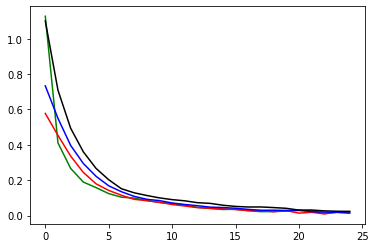

In [ ]:
import matplotlib.pyplot as plt

loss_list_16 = [1.1268876791000366, 0.41091328859329224, 0.26682642102241516, 0.18981273472309113, 0.1585627794265747, 0.12462582439184189, 0.10439462214708328, 0.09923368692398071, 0.0861586406826973, 0.074553482234478, 0.06842844933271408, 0.05831009894609451, 0.04693516343832016, 0.04028552398085594, 0.03476426377892494, 0.03636551648378372, 0.027629371732473373, 0.02270563319325447, 0.023278960958123207, 0.02576974220573902, 0.028956500813364983, 0.026662178337574005, 0.01205827109515667, 0.01900443248450756, 0.017517095431685448]
loss_list_32 = [0.5778000950813293, 0.45349517464637756, 0.3365524709224701, 0.24430455267429352, 0.17990316450595856, 0.14272713661193848, 0.11536013334989548, 0.09248892962932587, 0.0844212993979454, 0.07556392252445221, 0.06297740340232849, 0.05454753339290619, 0.04521776735782623, 0.041906196624040604, 0.038973744958639145, 0.03417503088712692, 0.029203122481703758, 0.028163660317659378, 0.022288044914603233, 0.028432272374629974, 0.01426108367741108, 0.019080979749560356, 0.009802976623177528, 0.019739139825105667, 0.02278626710176468]
loss_list_64 = [0.7336003184318542, 0.5498955845832825, 0.3969078063964844, 0.29476746916770935, 0.22255413234233856, 0.16873212158679962, 0.13528117537498474, 0.10923530161380768, 0.09243155270814896, 0.08499571681022644, 0.07158724963665009, 0.06311731785535812, 0.056249313056468964, 0.048009131103754044, 0.04591318592429161, 0.041753821074962616, 0.03545118495821953, 0.03043154627084732, 0.03077448345720768, 0.029365094378590584, 0.031014489009976387, 0.02227487601339817, 0.020090047270059586, 0.018755009397864342, 0.014285420998930931]
loss_list_128 = [1.1001505851745605, 0.7088683247566223, 0.4939412474632263, 0.3607051968574524, 0.2672146260738373, 0.2029889076948166, 0.15222841501235962, 0.1293368935585022, 0.11396116018295288, 0.10045761615037918, 0.09055810421705246, 0.08380580693483353, 0.07322715222835541, 0.06939279288053513, 0.05898356810212135, 0.05217868089675903, 0.04889925196766853, 0.04909573867917061, 0.045657578855752945, 0.04147873446345329, 0.0313851535320282, 0.03186754882335663, 0.02699873223900795, 0.024873340502381325, 0.024105535820126534]
loss_list_256 = []

plt.plot(range(25), loss_list_16, color='green')
plt.plot(range(25), loss_list_32, color='red')
plt.plot(range(25), loss_list_64, color='blue')
plt.plot(range(25), loss_list_128, color='black')
print(loss_list_16[-1])
print(loss_list_32[-1])
print(loss_list_64[-1])
print(loss_list_128[-1])

Looking at the graph of losses we will pick 10 epochs for our model

start doing some inference on own tweets

## Grid search for learning rate and batch size

In [ ]:
batch_size = 32
init_lr = 0.0001
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


AUTOTUNE = tf.data.AUTOTUNE
# training and validation dataset

train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)))

train_val_set_size = len(list(train_val_data))
val_n = int(0.2*train_val_set_size)

train_data = train_val_data.skip(val_n).batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = train_val_data.take(val_n).batch(batch_size)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

# test dataset

test_data = tf.data.experimental.CsvDataset(["test_bert"], [tf.string,tf.int32] ,select_cols=[2,3])
test_data = test_data.batch(batch_size)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

epochs = 25
list_dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for dropout in list_dropouts:
  print(f"Current dropout is {dropout}")
  classifier = build_classifier_model(dropout)
  classifier.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  history = classifier.fit(x=train_data, validation_data=val_data, epochs=epochs)
  history_dict=history.history
  print(f"For dropout {dropout}")
  print(history_dict['loss'])
  print(history_dict['val_loss'])
  print(history_dict['binary_accuracy'])
  print(history_dict['val_binary_accuracy'])

Learning rate of 0.01 is way too high

In [ ]:
epochs = 25

learning_rate_list = [0.001, 0.0005, 0.0001]  
batch_size_list = [16, 32, 64, 128, 256]

for rate in learning_rate_list:
  for size in batch_size_list:
    batch_size = size
    init_lr = rate

    AUTOTUNE = tf.data.AUTOTUNE
    # training and validation dataset
    train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

    train_val_data.shuffle(buffer_size=len(list(train_val_data)), seed = 12345)

    train_val_set_size = len(list(train_val_data))
    val_n = int(0.2*train_val_set_size)

    train_data = train_val_data.skip(val_n).batch(batch_size)
    train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
    val_data = train_val_data.take(val_n).batch(batch_size)
    val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

    steps_per_epoch = train_val_set_size - val_n
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')

    classifier = build_classifier_model(0)
    classifier.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)
    history = classifier.fit(x=train_data, validation_data=val_data, epochs=epochs)
    history_dict=history.history
    print(f"Learning rate {rate}, Batch size {size}")
    print(history_dict['loss'])
    print(history_dict['val_loss'])
    print(history_dict['binary_accuracy'])
    print(history_dict['val_binary_accuracy'])

Epoch 1/25
458/458 [==============================] - 28s 40ms/step - loss: 0.3924 - binary_accuracy: 0.8356 - val_loss: 0.1873 - val_binary_accuracy: 0.9175
Epoch 2/25
458/458 [==============================] - 18s 38ms/step - loss: 0.1679 - binary_accuracy: 0.9409 - val_loss: 0.1225 - val_binary_accuracy: 0.9617
Epoch 3/25
458/458 [==============================] - 18s 38ms/step - loss: 0.1129 - binary_accuracy: 0.9676 - val_loss: 0.1068 - val_binary_accuracy: 0.9721
Epoch 4/25
458/458 [==============================] - 18s 39ms/step - loss: 0.0920 - binary_accuracy: 0.9762 - val_loss: 0.1134 - val_binary_accuracy: 0.9765
Epoch 5/25
458/458 [==============================] - 18s 39ms/step - loss: 0.0777 - binary_accuracy: 0.9783 - val_loss: 0.1236 - val_binary_accuracy: 0.9760
Epoch 6/25
458/458 [==============================] - 18s 39ms/step - loss: 0.0638 - binary_accuracy: 0.9843 - val_loss: 0.1311 - val_binary_accuracy: 0.9732
Epoch 7/25
458/458 [==============================] 

KeyboardInterrupt: ignored

In [ ]:
epochs = 25

learning_rate_list = [0.0005, 0.0001]  
batch_size_list = [16, 32, 64, 128, 256]

for rate in learning_rate_list:
  for size in batch_size_list:
    batch_size = size
    init_lr = rate

    AUTOTUNE = tf.data.AUTOTUNE
    # training and validation dataset
    train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

    train_val_data.shuffle(buffer_size=len(list(train_val_data)), seed = 12345)

    train_val_set_size = len(list(train_val_data))
    val_n = int(0.2*train_val_set_size)

    train_data = train_val_data.skip(val_n).batch(batch_size)
    train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
    val_data = train_val_data.take(val_n).batch(batch_size)
    val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

    steps_per_epoch = train_val_set_size - val_n
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')

    classifier = build_classifier_model(0)
    classifier.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)
    history = classifier.fit(x=train_data, validation_data=val_data, epochs=epochs)
    history_dict=history.history
    print(f"Learning rate {rate}, Batch size {size}")
    print(history_dict['loss'])
    print(history_dict['val_loss'])
    print(history_dict['binary_accuracy'])
    print(history_dict['val_binary_accuracy'])

Epoch 1/25
458/458 [==============================] - 32s 41ms/step - loss: 0.4799 - binary_accuracy: 0.7586 - val_loss: 0.2506 - val_binary_accuracy: 0.8995
Epoch 2/25
458/458 [==============================] - 18s 40ms/step - loss: 0.2231 - binary_accuracy: 0.9123 - val_loss: 0.1502 - val_binary_accuracy: 0.9519
Epoch 3/25
458/458 [==============================] - 18s 39ms/step - loss: 0.1422 - binary_accuracy: 0.9534 - val_loss: 0.1295 - val_binary_accuracy: 0.9705
Epoch 4/25
458/458 [==============================] - 18s 39ms/step - loss: 0.1121 - binary_accuracy: 0.9674 - val_loss: 0.1173 - val_binary_accuracy: 0.9699
Epoch 5/25
458/458 [==============================] - 18s 39ms/step - loss: 0.0891 - binary_accuracy: 0.9754 - val_loss: 0.1116 - val_binary_accuracy: 0.9749
Epoch 6/25
458/458 [==============================] - 18s 39ms/step - loss: 0.0754 - binary_accuracy: 0.9809 - val_loss: 0.1464 - val_binary_accuracy: 0.9721
Epoch 7/25
458/458 [==============================] 

In [ ]:
init_lr = 0.0001 
batch_size = 128
epochs = 33

AUTOTUNE = tf.data.AUTOTUNE
# training and validation dataset
train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)), seed = 12345)

train_val_set_size = len(list(train_val_data))
val_n = int(0.2*train_val_set_size)

train_data = train_val_data.skip(val_n).batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = train_val_data.take(val_n).batch(batch_size)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = train_val_set_size - val_n
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier = build_classifier_model(0)
classifier.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history = classifier.fit(x=train_data, validation_data=val_data, epochs=epochs)
history_dict=history.history
print(f"Learning rate {init_lr}, Batch size {batch_size}")
print(history_dict['loss'])
print(history_dict['val_loss'])
print(history_dict['binary_accuracy'])
print(history_dict['val_binary_accuracy'])

init_lr = 0.0001 
batch_size = 256
epochs = 60

AUTOTUNE = tf.data.AUTOTUNE
# training and validation dataset
train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)), seed = 12345)

train_val_set_size = len(list(train_val_data))
val_n = int(0.2*train_val_set_size)

train_data = train_val_data.skip(val_n).batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = train_val_data.take(val_n).batch(batch_size)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = train_val_set_size - val_n
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier = build_classifier_model(0)
classifier.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history = classifier.fit(x=train_data, validation_data=val_data, epochs=epochs)
history_dict=history.history
print(f"Learning rate {init_lr}, Batch size {batch_size}")
print(history_dict['loss'])
print(history_dict['val_loss'])
print(history_dict['binary_accuracy'])
print(history_dict['val_binary_accuracy'])


Epoch 1/33
58/58 [==============================] - 46s 574ms/step - loss: 0.9013 - binary_accuracy: 0.3711 - val_loss: 0.8915 - val_binary_accuracy: 0.3557
Epoch 2/33
58/58 [==============================] - 32s 555ms/step - loss: 0.8634 - binary_accuracy: 0.4132 - val_loss: 0.8325 - val_binary_accuracy: 0.4623
Epoch 3/33
58/58 [==============================] - 32s 555ms/step - loss: 0.7977 - binary_accuracy: 0.5300 - val_loss: 0.7487 - val_binary_accuracy: 0.6175
Epoch 4/33
58/58 [==============================] - 32s 556ms/step - loss: 0.7175 - binary_accuracy: 0.6417 - val_loss: 0.6650 - val_binary_accuracy: 0.6705
Epoch 5/33
58/58 [==============================] - 32s 557ms/step - loss: 0.6523 - binary_accuracy: 0.6696 - val_loss: 0.5988 - val_binary_accuracy: 0.6710
Epoch 6/33
58/58 [==============================] - 32s 560ms/step - loss: 0.5941 - binary_accuracy: 0.6745 - val_loss: 0.5360 - val_binary_accuracy: 0.6749
Epoch 7/33
58/58 [==============================] - 32s 55

KeyboardInterrupt: ignored

In [ ]:
init_lr = 0.0001 
batch_size = 256
epochs = 60

AUTOTUNE = tf.data.AUTOTUNE
# training and validation dataset
train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)), seed = 12345)

train_val_set_size = len(list(train_val_data))
val_n = int(0.2*train_val_set_size)

train_data = train_val_data.skip(val_n).batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = train_val_data.take(val_n).batch(batch_size)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = train_val_set_size - val_n
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier = build_classifier_model(0)
classifier.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history = classifier.fit(x=train_data, validation_data=val_data, epochs=epochs)
history_dict=history.history
print(f"Learning rate {init_lr}, Batch size {batch_size}")
print(history_dict['loss'])
print(history_dict['val_loss'])
print(history_dict['binary_accuracy'])
print(history_dict['val_binary_accuracy'])

Epoch 1/60
29/29 [==============================] - 66s 2s/step - loss: 0.7902 - binary_accuracy: 0.5347 - val_loss: 0.7611 - val_binary_accuracy: 0.6022
Epoch 2/60
29/29 [==============================] - 58s 2s/step - loss: 0.7853 - binary_accuracy: 0.5647 - val_loss: 0.7539 - val_binary_accuracy: 0.6071
Epoch 3/60
29/29 [==============================] - 58s 2s/step - loss: 0.7782 - binary_accuracy: 0.5730 - val_loss: 0.7427 - val_binary_accuracy: 0.6219
Epoch 4/60
29/29 [==============================] - 58s 2s/step - loss: 0.7622 - binary_accuracy: 0.5957 - val_loss: 0.7284 - val_binary_accuracy: 0.6448
Epoch 5/60
29/29 [==============================] - 58s 2s/step - loss: 0.7474 - binary_accuracy: 0.6073 - val_loss: 0.7125 - val_binary_accuracy: 0.6601
Epoch 6/60
29/29 [==============================] - 58s 2s/step - loss: 0.7287 - binary_accuracy: 0.6267 - val_loss: 0.6955 - val_binary_accuracy: 0.6661
Epoch 7/60
29/29 [==============================] - 58s 2s/step - loss: 0.70

KeyboardInterrupt: ignored

In [ ]:
tf.random.set_seed(12345)

epochs = 6

batch_size = 32
init_lr = 0.001

AUTOTUNE = tf.data.AUTOTUNE
# training and validation dataset
train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32], select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)))
train_val_set_size = len(list(train_val_data))
val_n = int(0.2*train_val_set_size)

train_data = train_val_data.skip(val_n).batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = train_val_data.take(val_n).batch(batch_size)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = train_val_set_size - val_n
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

final_classifier = build_classifier_model(0)
final_classifier.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history = final_classifier.fit(x=train_data, validation_data=val_data, epochs=epochs)

final_classifier.save_weights('final_classifier')

Epoch 1/6
229/229 [==============================] - 42s 143ms/step - loss: 0.3711 - binary_accuracy: 0.8470 - val_loss: 0.1399 - val_binary_accuracy: 0.9454
Epoch 2/6
229/229 [==============================] - 31s 134ms/step - loss: 0.1371 - binary_accuracy: 0.9544 - val_loss: 0.0972 - val_binary_accuracy: 0.9689
Epoch 3/6
229/229 [==============================] - 31s 134ms/step - loss: 0.0970 - binary_accuracy: 0.9698 - val_loss: 0.0924 - val_binary_accuracy: 0.9738
Epoch 4/6
229/229 [==============================] - 31s 137ms/step - loss: 0.0813 - binary_accuracy: 0.9743 - val_loss: 0.1323 - val_binary_accuracy: 0.9705
Epoch 5/6
229/229 [==============================] - 31s 134ms/step - loss: 0.0676 - binary_accuracy: 0.9796 - val_loss: 0.1319 - val_binary_accuracy: 0.9727
Epoch 6/6
229/229 [==============================] - 31s 134ms/step - loss: 0.0559 - binary_accuracy: 0.9852 - val_loss: 0.1275 - val_binary_accuracy: 0.9689


In [ ]:
model = build_classifier_model(0)
model.load_weights('final_classifier')

In [ ]:
test_data = tf.data.experimental.CsvDataset(["test_bert"], [tf.string,tf.int32] ,select_cols=[2,3])
test_data = test_data.batch(batch_size)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.evaluate(test_data)

72/72 [==============================] - 8s 99ms/step - loss: 0.2204 - binary_accuracy: 0.9597


[0.22041814029216766, 0.9596891403198242]

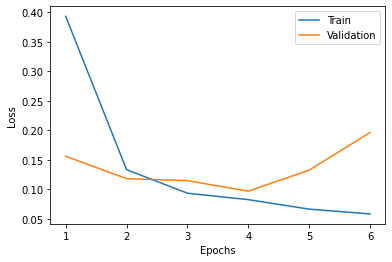

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,7), history.history['loss'], label='Train')
plt.plot(range(1,7), history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

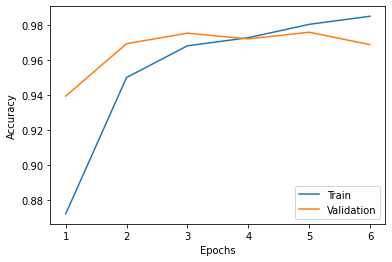

In [ ]:
plt.plot(range(1,7), history.history['binary_accuracy'], label='Train')
plt.plot(range(1,7), history.history['val_binary_accuracy'],  label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("accuracy_final.png")

## Cross- validation on final model

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
# training and validation dataset
train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32], select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)), seed = 12345)

train_val_set_size = len(list(train_val_data))

split_size = int(0.2*train_val_set_size)

batch_size = 32

cv_1 = train_val_data.take(split_size).batch(batch_size)
cv_1 = cv_1.cache().prefetch(buffer_size=AUTOTUNE)
m1 = train_val_data.skip(split_size)
cv_2 = m1.take(split_size).batch(batch_size)
cv_2 = cv_2.cache().prefetch(buffer_size=AUTOTUNE)
m2 = m1.skip(split_size)
cv_3 = m2.take(split_size).batch(batch_size)
cv_3 = cv_3.cache().prefetch(buffer_size=AUTOTUNE)
m3 = m2.skip(split_size)
cv_4 = m3.take(split_size).batch(batch_size)
cv_4 = cv_4.cache().prefetch(buffer_size=AUTOTUNE)
cv_5 = m3.skip(split_size).batch(batch_size)
cv_5 = cv_5.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
acc_fold = []
val_acc_fold = []
loss_fold = []
val_loss_fold = []

init_lr = 0.001
epochs = 6

steps_per_epoch = train_val_set_size - split_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)


# fold 1
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv1 = build_classifier_model(0)
classifier_model_cv1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv1 = classifier_model_cv1.fit(x=cv_2.concatenate(cv_3).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_1,
                               epochs=epcochs)
history_dict_cv1 = history_cv1.history

acc_fold.append(history_dict_cv1['binary_accuracy'])
val_acc_fold.append(history_dict_cv1['val_binary_accuracy'])
loss_fold.append(history_dict_cv1['loss'])
val_loss_fold.append(history_dict_cv1['val_loss'])

# fold 2
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv2 = build_classifier_model(0)
classifier_model_cv2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv2 = classifier_model_cv2.fit(x=cv_1.concatenate(cv_3).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_2,
                               epochs=epochs)
history_dict_cv2 = history_cv2.history

acc_fold.append(history_dict_cv2['binary_accuracy'])
val_acc_fold.append(history_dict_cv2['val_binary_accuracy'])
loss_fold.append(history_dict_cv2['loss'])
val_loss_fold.append(history_dict_cv2['val_loss'])

#fold 3
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv3 = build_classifier_model(0)
classifier_model_cv3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv3 = classifier_model_cv3.fit(x=cv_2.concatenate(cv_1).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_3,
                               epochs=epochs)
history_dict_cv3 = history_cv3.history

acc_fold.append(history_dict_cv3['binary_accuracy'])
val_acc_fold.append(history_dict_cv3['val_binary_accuracy'])
loss_fold.append(history_dict_cv3['loss'])
val_loss_fold.append(history_dict_cv3['val_loss'])

# fold 4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv4 = build_classifier_model(0)
classifier_model_cv4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv4 = classifier_model_cv4.fit(x=cv_2.concatenate(cv_3).concatenate(cv_1).concatenate(cv_5),
                               validation_data=cv_4,
                               epochs=epochs)
history_dict_cv4 = history_cv4.history

acc_fold.append(history_dict_cv4['binary_accuracy'])
val_acc_fold.append(history_dict_cv4['val_binary_accuracy'])
loss_fold.append(history_dict_cv4['loss'])
val_loss_fold.append(history_dict_cv4['val_loss'])

#fold 5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv5 = build_classifier_model(0)
classifier_model_cv5.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv5 = classifier_model_cv5.fit(x=cv_2.concatenate(cv_3).concatenate(cv_4).concatenate(cv_1),
                               validation_data=cv_5,
                               epochs=epochs)
history_dict_cv5 = history_cv5.history

acc_fold.append(history_dict_cv5['binary_accuracy'])
val_acc_fold.append(history_dict_cv5['val_binary_accuracy'])
loss_fold.append(history_dict_cv5['loss'])
val_loss_fold.append(history_dict_cv5['val_loss'])

# print
print(acc_fold)
print(val_acc_fold)
print(loss_fold)
print(val_loss_fold)

Epoch 1/6
232/232 [==============================] - 43s 135ms/step - loss: 0.3776 - binary_accuracy: 0.8183 - val_loss: 0.1559 - val_binary_accuracy: 0.9437
Epoch 2/6
232/232 [==============================] - 31s 134ms/step - loss: 0.1467 - binary_accuracy: 0.9495 - val_loss: 0.0814 - val_binary_accuracy: 0.9732
Epoch 3/6
232/232 [==============================] - 31s 135ms/step - loss: 0.0998 - binary_accuracy: 0.9676 - val_loss: 0.0834 - val_binary_accuracy: 0.9749
Epoch 4/6
232/232 [==============================] - 30s 130ms/step - loss: 0.0769 - binary_accuracy: 0.9761 - val_loss: 0.1004 - val_binary_accuracy: 0.9765
Epoch 5/6
232/232 [==============================] - 31s 133ms/step - loss: 0.0653 - binary_accuracy: 0.9821 - val_loss: 0.1623 - val_binary_accuracy: 0.9628
Epoch 6/6
232/232 [==============================] - 30s 130ms/step - loss: 0.0558 - binary_accuracy: 0.9863 - val_loss: 0.1709 - val_binary_accuracy: 0.9672
Epoch 1/6
232/232 [==============================] -

# redo entire grid search with early stopping and a set seed

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)

epochs = 25

learning_rate_list = [0.001, 0.0005, 0.0001]  
batch_size_list = [16, 32, 64, 128, 256]

for rate in learning_rate_list:
  for size in batch_size_list:
    tf.random.set_seed(12345)

    batch_size = size
    init_lr = rate

    AUTOTUNE = tf.data.AUTOTUNE
    # training and validation dataset
    train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

    train_val_data.shuffle(buffer_size=len(list(train_val_data)))

    train_val_set_size = len(list(train_val_data))
    val_n = int(0.2*train_val_set_size)

    train_data = train_val_data.skip(val_n).batch(batch_size)
    train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
    val_data = train_val_data.take(val_n).batch(batch_size)
    val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

    steps_per_epoch = train_val_set_size - val_n
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                             num_train_steps=num_train_steps,
                                             num_warmup_steps=num_warmup_steps,
                                             optimizer_type='adamw')

    classifier = build_classifier_model(0)
    classifier.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)
    history = classifier.fit(x=train_data, validation_data=val_data, epochs=epochs, callbacks=[es])
    history_dict=history.history
    print(f"Learning rate {rate}, Batch size {size}")
    print(history_dict['loss'])
    print(history_dict['val_loss'])
    print(history_dict['binary_accuracy'])
    print(history_dict['val_binary_accuracy'])

Epoch 1/25
458/458 [==============================] - 38s 65ms/step - loss: 0.3966 - binary_accuracy: 0.7761 - val_loss: 0.1758 - val_binary_accuracy: 0.9268
Epoch 2/25
458/458 [==============================] - 29s 64ms/step - loss: 0.1653 - binary_accuracy: 0.9418 - val_loss: 0.1148 - val_binary_accuracy: 0.9694
Epoch 3/25
458/458 [==============================] - 29s 63ms/step - loss: 0.1186 - binary_accuracy: 0.9650 - val_loss: 0.1278 - val_binary_accuracy: 0.9694
Epoch 4/25
458/458 [==============================] - 29s 64ms/step - loss: 0.1006 - binary_accuracy: 0.9717 - val_loss: 0.1099 - val_binary_accuracy: 0.9765
Epoch 5/25
458/458 [==============================] - 29s 64ms/step - loss: 0.0792 - binary_accuracy: 0.9780 - val_loss: 0.1550 - val_binary_accuracy: 0.9727
Epoch 6/25
458/458 [==============================] - 30s 65ms/step - loss: 0.0647 - binary_accuracy: 0.9822 - val_loss: 0.1366 - val_binary_accuracy: 0.9738
Epoch 7/25
458/458 [==============================] 

KeyboardInterrupt: ignored

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)

epochs = 25

# need to run 0.001, 256 and 0.0005, 256 and 0.0001, 128 and 0.0001, 256

learning_rate_list = [0.001]  
batch_size_list = [256]

for rate in learning_rate_list:
  for size in batch_size_list:
    tf.random.set_seed(12345)

    batch_size = size
    init_lr = rate

    AUTOTUNE = tf.data.AUTOTUNE
    # training and validation dataset
    train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

    train_val_data.shuffle(buffer_size=len(list(train_val_data)))

    train_val_set_size = len(list(train_val_data))
    val_n = int(0.2*train_val_set_size)

    train_data = train_val_data.skip(val_n).batch(batch_size)
    train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
    val_data = train_val_data.take(val_n).batch(batch_size)
    val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

    steps_per_epoch = train_val_set_size - val_n
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                             num_train_steps=num_train_steps,
                                             num_warmup_steps=num_warmup_steps,
                                             optimizer_type='adamw')

    classifier = build_classifier_model(0)
    classifier.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)
    history = classifier.fit(x=train_data, validation_data=val_data, epochs=100, callbacks=[es])
    history_dict=history.history
    print(f"Learning rate {rate}, Batch size {size}")
    print(history_dict['loss'])
    print(history_dict['val_loss'])
    print(history_dict['binary_accuracy'])
    print(history_dict['val_binary_accuracy'])

Epoch 1/100
29/29 [==============================] - 72s 2s/step - loss: 0.6392 - binary_accuracy: 0.6704 - val_loss: 0.6223 - val_binary_accuracy: 0.6710
Epoch 2/100
29/29 [==============================] - 58s 2s/step - loss: 0.5905 - binary_accuracy: 0.6708 - val_loss: 0.5456 - val_binary_accuracy: 0.6727
Epoch 3/100
29/29 [==============================] - 58s 2s/step - loss: 0.5225 - binary_accuracy: 0.6920 - val_loss: 0.4615 - val_binary_accuracy: 0.7306
Epoch 4/100
29/29 [==============================] - 58s 2s/step - loss: 0.4547 - binary_accuracy: 0.7566 - val_loss: 0.3871 - val_binary_accuracy: 0.8131
Epoch 5/100
29/29 [==============================] - 58s 2s/step - loss: 0.3905 - binary_accuracy: 0.8166 - val_loss: 0.3194 - val_binary_accuracy: 0.8678
Epoch 6/100
29/29 [==============================] - 58s 2s/step - loss: 0.3280 - binary_accuracy: 0.8605 - val_loss: 0.2659 - val_binary_accuracy: 0.8929
Epoch 7/100
29/29 [==============================] - 58s 2s/step - los

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)

epochs = 25

# need to run 0.001, 256 and 0.0005, 256 and 0.0001, 128 and 0.0001, 256

learning_rate_list = [0.0005]  
batch_size_list = [256]

for rate in learning_rate_list:
  for size in batch_size_list:
    tf.random.set_seed(12345)

    batch_size = size
    init_lr = rate

    AUTOTUNE = tf.data.AUTOTUNE
    # training and validation dataset
    train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

    train_val_data.shuffle(buffer_size=len(list(train_val_data)))

    train_val_set_size = len(list(train_val_data))
    val_n = int(0.2*train_val_set_size)

    train_data = train_val_data.skip(val_n).batch(batch_size)
    train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
    val_data = train_val_data.take(val_n).batch(batch_size)
    val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

    steps_per_epoch = train_val_set_size - val_n
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                             num_train_steps=num_train_steps,
                                             num_warmup_steps=num_warmup_steps,
                                             optimizer_type='adamw')

    classifier = build_classifier_model(0)
    classifier.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)
    history = classifier.fit(x=train_data, validation_data=val_data, epochs=100, callbacks=[es])
    history_dict=history.history
    print(f"Learning rate {rate}, Batch size {size}")
    print(history_dict['loss'])
    print(history_dict['val_loss'])
    print(history_dict['binary_accuracy'])
    print(history_dict['val_binary_accuracy'])

Epoch 1/100
29/29 [==============================] - 67s 2s/step - loss: 0.6422 - binary_accuracy: 0.7311 - val_loss: 0.6375 - val_binary_accuracy: 0.6710
Epoch 2/100
29/29 [==============================] - 58s 2s/step - loss: 0.6193 - binary_accuracy: 0.6704 - val_loss: 0.5927 - val_binary_accuracy: 0.6710
Epoch 3/100
29/29 [==============================] - 58s 2s/step - loss: 0.5722 - binary_accuracy: 0.6722 - val_loss: 0.5307 - val_binary_accuracy: 0.6738
Epoch 4/100
29/29 [==============================] - 58s 2s/step - loss: 0.5235 - binary_accuracy: 0.6906 - val_loss: 0.4705 - val_binary_accuracy: 0.7169
Epoch 5/100
29/29 [==============================] - 58s 2s/step - loss: 0.4711 - binary_accuracy: 0.7345 - val_loss: 0.4150 - val_binary_accuracy: 0.7814
Epoch 6/100
29/29 [==============================] - 58s 2s/step - loss: 0.4215 - binary_accuracy: 0.7907 - val_loss: 0.3635 - val_binary_accuracy: 0.8301
Epoch 7/100
29/29 [==============================] - 58s 2s/step - los

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)

epochs = 25

# need to run 0.001, 256 and 0.0005, 256 and 0.0001, 128 and 0.0001, 256

learning_rate_list = [0.0001]  
batch_size_list = [128, 256]

for rate in learning_rate_list:
  for size in batch_size_list:
    tf.random.set_seed(12345)

    batch_size = size
    init_lr = rate

    AUTOTUNE = tf.data.AUTOTUNE
    # training and validation dataset
    train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32] ,select_cols=[2,3])

    train_val_data.shuffle(buffer_size=len(list(train_val_data)))

    train_val_set_size = len(list(train_val_data))
    val_n = int(0.2*train_val_set_size)

    train_data = train_val_data.skip(val_n).batch(batch_size)
    train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
    val_data = train_val_data.take(val_n).batch(batch_size)
    val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

    steps_per_epoch = train_val_set_size - val_n
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                             num_train_steps=num_train_steps,
                                             num_warmup_steps=num_warmup_steps,
                                             optimizer_type='adamw')

    classifier = build_classifier_model(0)
    classifier.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)
    history = classifier.fit(x=train_data, validation_data=val_data, epochs=100, callbacks=[es])
    history_dict=history.history
    print(f"Learning rate {rate}, Batch size {size}")
    print(history_dict['loss'])
    print(history_dict['val_loss'])
    print(history_dict['binary_accuracy'])
    print(history_dict['val_binary_accuracy'])

Epoch 1/100
58/58 [==============================] - 41s 570ms/step - loss: 0.6431 - binary_accuracy: 0.7308 - val_loss: 0.6411 - val_binary_accuracy: 0.6710
Epoch 2/100
58/58 [==============================] - 32s 559ms/step - loss: 0.6249 - binary_accuracy: 0.6704 - val_loss: 0.6066 - val_binary_accuracy: 0.6710
Epoch 3/100
58/58 [==============================] - 32s 557ms/step - loss: 0.5874 - binary_accuracy: 0.6708 - val_loss: 0.5561 - val_binary_accuracy: 0.6721
Epoch 4/100
58/58 [==============================] - 32s 557ms/step - loss: 0.5468 - binary_accuracy: 0.6753 - val_loss: 0.5028 - val_binary_accuracy: 0.6863
Epoch 5/100
58/58 [==============================] - 32s 554ms/step - loss: 0.5017 - binary_accuracy: 0.7076 - val_loss: 0.4556 - val_binary_accuracy: 0.7306
Epoch 6/100
58/58 [==============================] - 32s 560ms/step - loss: 0.4637 - binary_accuracy: 0.7424 - val_loss: 0.4134 - val_binary_accuracy: 0.7820
Epoch 7/100
58/58 [==============================] -

In [ ]:
tf.random.set_seed(12345)
AUTOTUNE = tf.data.AUTOTUNE
# training and validation dataset
train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32], select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)), seed = 12345)

train_val_set_size = len(list(train_val_data))

split_size = int(0.2*train_val_set_size)

batch_size = 16

cv_1 = train_val_data.take(split_size).batch(batch_size)
cv_1 = cv_1.cache().prefetch(buffer_size=AUTOTUNE)
m1 = train_val_data.skip(split_size)
cv_2 = m1.take(split_size).batch(batch_size)
cv_2 = cv_2.cache().prefetch(buffer_size=AUTOTUNE)
m2 = m1.skip(split_size)
cv_3 = m2.take(split_size).batch(batch_size)
cv_3 = cv_3.cache().prefetch(buffer_size=AUTOTUNE)
m3 = m2.skip(split_size)
cv_4 = m3.take(split_size).batch(batch_size)
cv_4 = cv_4.cache().prefetch(buffer_size=AUTOTUNE)
cv_5 = m3.skip(split_size).batch(batch_size)
cv_5 = cv_5.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
acc_fold = []
val_acc_fold = []
loss_fold = []
val_loss_fold = []

init_lr = 0.001
epochs = 25

steps_per_epoch = train_val_set_size - split_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)


# fold 1
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv1 = build_classifier_model(0)
classifier_model_cv1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv1 = classifier_model_cv1.fit(x=cv_2.concatenate(cv_3).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_1,
                               epochs=7)
history_dict_cv1 = history_cv1.history

acc_fold.append(history_dict_cv1['binary_accuracy'])
val_acc_fold.append(history_dict_cv1['val_binary_accuracy'])
loss_fold.append(history_dict_cv1['loss'])
val_loss_fold.append(history_dict_cv1['val_loss'])

# fold 2
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv2 = build_classifier_model(0)
classifier_model_cv2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv2 = classifier_model_cv2.fit(x=cv_1.concatenate(cv_3).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_2,
                               epochs=7)
history_dict_cv2 = history_cv2.history

acc_fold.append(history_dict_cv2['binary_accuracy'])
val_acc_fold.append(history_dict_cv2['val_binary_accuracy'])
loss_fold.append(history_dict_cv2['loss'])
val_loss_fold.append(history_dict_cv2['val_loss'])

#fold 3
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv3 = build_classifier_model(0)
classifier_model_cv3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv3 = classifier_model_cv3.fit(x=cv_2.concatenate(cv_1).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_3,
                               epochs=7)
history_dict_cv3 = history_cv3.history

acc_fold.append(history_dict_cv3['binary_accuracy'])
val_acc_fold.append(history_dict_cv3['val_binary_accuracy'])
loss_fold.append(history_dict_cv3['loss'])
val_loss_fold.append(history_dict_cv3['val_loss'])

# fold 4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv4 = build_classifier_model(0)
classifier_model_cv4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv4 = classifier_model_cv4.fit(x=cv_2.concatenate(cv_3).concatenate(cv_1).concatenate(cv_5),
                               validation_data=cv_4,
                               epochs=7)
history_dict_cv4 = history_cv4.history

acc_fold.append(history_dict_cv4['binary_accuracy'])
val_acc_fold.append(history_dict_cv4['val_binary_accuracy'])
loss_fold.append(history_dict_cv4['loss'])
val_loss_fold.append(history_dict_cv4['val_loss'])

#fold 5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv5 = build_classifier_model(0)
classifier_model_cv5.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv5 = classifier_model_cv5.fit(x=cv_2.concatenate(cv_3).concatenate(cv_4).concatenate(cv_1),
                               validation_data=cv_5,
                               epochs=7)
history_dict_cv5 = history_cv5.history

acc_fold.append(history_dict_cv5['binary_accuracy'])
val_acc_fold.append(history_dict_cv5['val_binary_accuracy'])
loss_fold.append(history_dict_cv5['loss'])
val_loss_fold.append(history_dict_cv5['val_loss'])

# print
print(acc_fold)
print(val_acc_fold)
print(loss_fold)
print(val_loss_fold)

Epoch 1/7
460/460 [==============================] - 42s 64ms/step - loss: 0.4385 - binary_accuracy: 0.7840 - val_loss: 0.1829 - val_binary_accuracy: 0.9355
Epoch 2/7
460/460 [==============================] - 29s 64ms/step - loss: 0.1678 - binary_accuracy: 0.9418 - val_loss: 0.1292 - val_binary_accuracy: 0.9661
Epoch 3/7
460/460 [==============================] - 29s 64ms/step - loss: 0.1236 - binary_accuracy: 0.9648 - val_loss: 0.1198 - val_binary_accuracy: 0.9738
Epoch 4/7
460/460 [==============================] - 30s 64ms/step - loss: 0.0957 - binary_accuracy: 0.9740 - val_loss: 0.1042 - val_binary_accuracy: 0.9738
Epoch 5/7
460/460 [==============================] - 29s 64ms/step - loss: 0.0836 - binary_accuracy: 0.9783 - val_loss: 0.1420 - val_binary_accuracy: 0.9743
Epoch 6/7
460/460 [==============================] - 29s 64ms/step - loss: 0.0646 - binary_accuracy: 0.9848 - val_loss: 0.1476 - val_binary_accuracy: 0.9721
Epoch 7/7
460/460 [==============================] - 29s 6

# Best final model

In [ ]:
tf.random.set_seed(12345)

epochs = 25

batch_size = 16
init_lr = 0.001

AUTOTUNE = tf.data.AUTOTUNE
# training and validation dataset
train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32], select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)))
train_val_set_size = len(list(train_val_data))
val_n = int(0.2*train_val_set_size)

train_data = train_val_data.skip(val_n).batch(batch_size)
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = train_val_data.take(val_n).batch(batch_size)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = train_val_set_size - val_n
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

final_classifier = build_classifier_model(0)
final_classifier.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history = final_classifier.fit(x=train_data, validation_data=val_data, epochs=7)

final_classifier.save_weights('final_classifier8')

Epoch 1/7
458/458 [==============================] - 39s 66ms/step - loss: 0.3965 - binary_accuracy: 0.8378 - val_loss: 0.1721 - val_binary_accuracy: 0.9366
Epoch 2/7
458/458 [==============================] - 31s 68ms/step - loss: 0.1663 - binary_accuracy: 0.9406 - val_loss: 0.1181 - val_binary_accuracy: 0.9656
Epoch 3/7
458/458 [==============================] - 31s 68ms/step - loss: 0.1149 - binary_accuracy: 0.9653 - val_loss: 0.1293 - val_binary_accuracy: 0.9716
Epoch 4/7
458/458 [==============================] - 31s 68ms/step - loss: 0.0975 - binary_accuracy: 0.9739 - val_loss: 0.1148 - val_binary_accuracy: 0.9732
Epoch 5/7
458/458 [==============================] - 32s 69ms/step - loss: 0.0834 - binary_accuracy: 0.9784 - val_loss: 0.1393 - val_binary_accuracy: 0.9716
Epoch 6/7
458/458 [==============================] - 31s 68ms/step - loss: 0.0684 - binary_accuracy: 0.9821 - val_loss: 0.1381 - val_binary_accuracy: 0.9705
Epoch 7/7
458/458 [==============================] - 31s 6

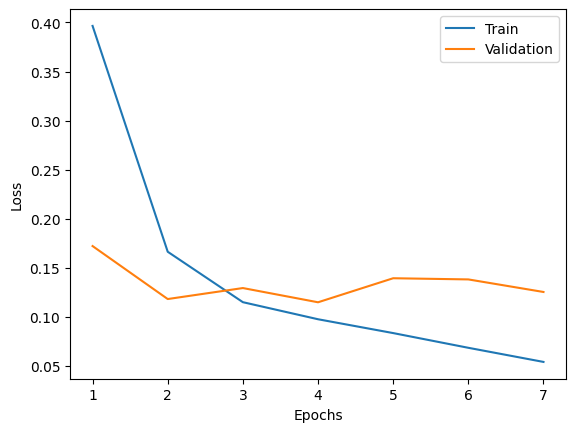

In [ ]:
train_loss = [0.3965, 0.1663, 0.1149, 0.0975, 0.0834, 0.0684, 0.0540]
validation_loss = [0.1721, 0.1181, 0.1293, 0.1148, 0.1393, 0.1381, 0.1253]

import matplotlib.pyplot as plt
plt.plot(range(1,8), train_loss, label='Train')
plt.plot(range(1,8), validation_loss , label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Loss_graph')

In [ ]:
model = build_classifier_model(0)
model.load_weights('final_classifier8')

In [ ]:
test_data = tf.data.experimental.CsvDataset(["test_bert"], [tf.string,tf.int32] ,select_cols=[2,3])
test_data = test_data.batch(batch_size)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.evaluate(test_data)

143/143 [==============================] - 5s 34ms/step - loss: 0.1724 - binary_accuracy: 0.9733


[0.1724161058664322, 0.9732879996299744]

on test set we get an accuracy of 0.9733

report accuracies in table on overleaf, save the model and test on the test set, do the test on the dataset of tweets

## Final cross validation 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
# training and validation dataset
train_val_data = tf.data.experimental.CsvDataset(["train_bert"], [tf.string,tf.int32], select_cols=[2,3])

train_val_data.shuffle(buffer_size=len(list(train_val_data)), seed = 12345)

train_val_set_size = len(list(train_val_data))

split_size = int(0.2*train_val_set_size)

batch_size = 32

cv_1 = train_val_data.take(split_size).batch(batch_size)
cv_1 = cv_1.cache().prefetch(buffer_size=AUTOTUNE)
m1 = train_val_data.skip(split_size)
cv_2 = m1.take(split_size).batch(batch_size)
cv_2 = cv_2.cache().prefetch(buffer_size=AUTOTUNE)
m2 = m1.skip(split_size)
cv_3 = m2.take(split_size).batch(batch_size)
cv_3 = cv_3.cache().prefetch(buffer_size=AUTOTUNE)
m3 = m2.skip(split_size)
cv_4 = m3.take(split_size).batch(batch_size)
cv_4 = cv_4.cache().prefetch(buffer_size=AUTOTUNE)
cv_5 = m3.skip(split_size).batch(batch_size)
cv_5 = cv_5.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
acc_fold = []
val_acc_fold = []
loss_fold = []
val_loss_fold = []

init_lr = 0.001
epochs = 25

steps_per_epoch = train_val_set_size - split_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)


# fold 1
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv1 = build_classifier_model(0)
classifier_model_cv1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv1 = classifier_model_cv1.fit(x=cv_2.concatenate(cv_3).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_1,
                               epochs=7)
history_dict_cv1 = history_cv1.history

acc_fold.append(history_dict_cv1['binary_accuracy'])
val_acc_fold.append(history_dict_cv1['val_binary_accuracy'])
loss_fold.append(history_dict_cv1['loss'])
val_loss_fold.append(history_dict_cv1['val_loss'])

# fold 2
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv2 = build_classifier_model(0)
classifier_model_cv2.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv2 = classifier_model_cv2.fit(x=cv_1.concatenate(cv_3).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_2,
                               epochs=7)
history_dict_cv2 = history_cv2.history

acc_fold.append(history_dict_cv2['binary_accuracy'])
val_acc_fold.append(history_dict_cv2['val_binary_accuracy'])
loss_fold.append(history_dict_cv2['loss'])
val_loss_fold.append(history_dict_cv2['val_loss'])

#fold 3
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv3 = build_classifier_model(0)
classifier_model_cv3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv3 = classifier_model_cv3.fit(x=cv_2.concatenate(cv_1).concatenate(cv_4).concatenate(cv_5),
                               validation_data=cv_3,
                               epochs=7)
history_dict_cv3 = history_cv3.history

acc_fold.append(history_dict_cv3['binary_accuracy'])
val_acc_fold.append(history_dict_cv3['val_binary_accuracy'])
loss_fold.append(history_dict_cv3['loss'])
val_loss_fold.append(history_dict_cv3['val_loss'])

# fold 4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv4 = build_classifier_model(0)
classifier_model_cv4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv4 = classifier_model_cv4.fit(x=cv_2.concatenate(cv_3).concatenate(cv_1).concatenate(cv_5),
                               validation_data=cv_4,
                               epochs=7)
history_dict_cv4 = history_cv4.history

acc_fold.append(history_dict_cv4['binary_accuracy'])
val_acc_fold.append(history_dict_cv4['val_binary_accuracy'])
loss_fold.append(history_dict_cv4['loss'])
val_loss_fold.append(history_dict_cv4['val_loss'])

#fold 5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model_cv5 = build_classifier_model(0)
classifier_model_cv5.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
history_cv5 = classifier_model_cv5.fit(x=cv_2.concatenate(cv_3).concatenate(cv_4).concatenate(cv_1),
                               validation_data=cv_5,
                               epochs=7)
history_dict_cv5 = history_cv5.history

acc_fold.append(history_dict_cv5['binary_accuracy'])
val_acc_fold.append(history_dict_cv5['val_binary_accuracy'])
loss_fold.append(history_dict_cv5['loss'])
val_loss_fold.append(history_dict_cv5['val_loss'])

# print
print(acc_fold)
print(val_acc_fold)
print(loss_fold)
print(val_loss_fold)

Epoch 1/7
232/232 [==============================] - 44s 139ms/step - loss: 0.5045 - binary_accuracy: 0.7518 - val_loss: 0.2938 - val_binary_accuracy: 0.8721
Epoch 2/7
232/232 [==============================] - 30s 130ms/step - loss: 0.2439 - binary_accuracy: 0.9002 - val_loss: 0.1527 - val_binary_accuracy: 0.9497
Epoch 3/7
232/232 [==============================] - 32s 138ms/step - loss: 0.1458 - binary_accuracy: 0.9471 - val_loss: 0.1106 - val_binary_accuracy: 0.9656
Epoch 4/7
232/232 [==============================] - 30s 130ms/step - loss: 0.1032 - binary_accuracy: 0.9679 - val_loss: 0.1149 - val_binary_accuracy: 0.9694
Epoch 5/7
232/232 [==============================] - 32s 137ms/step - loss: 0.0903 - binary_accuracy: 0.9728 - val_loss: 0.1109 - val_binary_accuracy: 0.9716
Epoch 6/7
232/232 [==============================] - 30s 130ms/step - loss: 0.0714 - binary_accuracy: 0.9779 - val_loss: 0.1230 - val_binary_accuracy: 0.9678
Epoch 7/7
232/232 [==============================] -

# Inference

In [ ]:
examples = ['For on-the-field cardiac arrests, this "Courageous Discourse" gives a key interpretative figure for those who have taken one of the mass mandated products at any time in the past.', 'If you were wise enough and strong enough not to take it, you have to read this piece!', 'Dr. Masanori Fukushima, a prof emeritus at Kyoto University, /25/22, raised concerns involving discrimination against the unvaccinated in Japan as well as an ever-growing list of persons reporting injuries associated with the COVID-19 mRNA vaccines.', 'Exclusive interview podcast with Ms. Jennifer Sharp who produced "Anecdotals" Must see documentary for those who had no side effects--gives them a view of the Russian Roulette faced on the next booster.']

predictions = tf.sigmoid(model(tf.constant(examples)))

print(predictions)

info = []

# 1 means misinformation and 0 means information

for i in predictions.numpy():
  if i[0] > 0.5:
    info.append(1)
  else:
    info.append(0)

print(sum(info)/len(info))


tf.Tensor(
[[1.0706730e-03]
 [1.6453305e-04]
 [9.9368566e-01]
 [6.4237352e-04]], shape=(4, 1), dtype=float32)
0.25


create dataframe with tweets labelled as inf and misinf

1 means misinformation and 1 means information

In [ ]:
model = build_classifier_model(0)
model.load_weights('final_classifier8')

In [ ]:
import pandas as pd
import ast
import numpy as np
from google.colab import files

df = pd.read_csv('cleaned_user_text_data.csv')
df['Misinformation'] = np.nan

for index, tweets in enumerate(df['Cleaned_Tweets']):
  
  if index % 10000 == 0:
    print(index)

  tweets = ast.literal_eval(tweets)
  predictions = tf.sigmoid(model(tf.constant(tweets)))

  info = []
  for i in predictions.numpy():
    if i[0] > 0.5:
      info.append(1)
    else:
      info.append(0)

  df.at[index, 'Misinformation'] = sum(info)/len(info)

df.to_csv('cleaned_user_text_data_misinf.csv')

files.download('cleaned_user_text_data_misinf.csv')

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

could look at how likely you are to be retweeted if you spread misinformation

In [ ]:
import pandas as pd
import numpy as np

df_misinf = pd.read_csv('cleaned_user_text_data_misinf.csv', usecols=['User_ID', 'Cleaned_Tweets', 'Misinformation'])

print(df_misinf['Misinformation'].mean())

0.28282141947858325


In [ ]:
df_cleaned = pd.read_csv('cleaned_user_text_data.csv', usecols=['User_ID', 'Cleaned_Tweets'])
print(df_cleaned.head())

FileNotFoundError: ignored

In [ ]:
pagerank_users = [1478792963090169860, 472777204, 120526471, 707231479047315456, 705902960967094272, 1465347964252180493]
names = ['healthbyjames', 'DrAseemMalhotra', 'Hey_Brian', 'PeterSweden7', 'EricSpracklen', 'P_McCulloughMD']

In [ ]:
import ast

def misinf_quotient_users(user_ids):
  for user, name in zip(user_ids, names):
    index = np.where(df_misinf['User_ID']==user)[0][0]
    list_tweets = ast.literal_eval(df_misinf['Cleaned_Tweets'][index])
    print(f"User is {name}, Misinformation quotient is {df_misinf['Misinformation'][index]}")
    #print(df_misinf['Misinformation'][index])
    #print(len(list_tweets))

In [ ]:
misinf_quotient_users(pagerank_users)

User is healthbyjames, Misinformation quotient is 0.3574468085106383
User is DrAseemMalhotra, Misinformation quotient is 0.7333333333333333
User is Hey_Brian, Misinformation quotient is 0.5
User is PeterSweden7, Misinformation quotient is 0.3703703703703703
User is EricSpracklen, Misinformation quotient is 0.2666666666666666
User is P_McCulloughMD, Misinformation quotient is 0.3846153846153846
